In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#!pip install transformers
!pip install transformers[SentencePiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

#keras
import tensorflow as tf
from tensorflow import keras


#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)


<Figure size 432x288 with 0 Axes>

## Custom functions definition:

In [ ]:
def conf_matrix(y, y_pred, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Negative', 'Neutral', 'Positive']
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()

# Loading the data

In [ ]:
dff = pd.read_csv('/content/drive/MyDrive/Models/annotated_3cat_3_random.csv')

In [ ]:
dff.dropna(inplace=True)
dff

,text,Sentiment
0,Bitcoin is unfolding like the dot com crash ju...,Neutral
1,XEM Price is 0 00003330 0 00000044 BTC 0 28641...,Negative
2,RT Bitcoin daily snapshot 24hr CHANGE 6 4 OUTL...,Neutral
3,Dutch Court Finds Bitcoin A Legitimate Transfe...,Neutral
4,BTC STEEM AskRate 0 00024274 Bittrex STEEM STE...,Positive
...,...,...
25098,The Image MASSter Solo 101 Forensic Hard Drive...,Negative
25099,Buy Bitcoin Bitcoin Cash Monero Zcash or Litec...,Positive
25100,In April 2016 computer technicians at the Demo...,Neutral
25101,The Gentlemen of Crypto EP 129 Bitcoin Blackli...,Neutral


In [ ]:
df, df_test = train_test_split(dff, random_state=42, test_size=0.1)

In [ ]:
df

,text,Sentiment
16432,RT A new survey of Americans has shown that cr...,Positive
7614,Fantatic,Neutral
3789,64 How to get started with google adsense affi...,Neutral
24483,RT New post Leaked Documents Reveals NSA Attem...,Positive
18080,AtlantaCyberAttack WHAT IN THE WORLD IS GOING ON,Neutral
...,...,...
21576,Also,Negative
5391,RT Japan s electric power provider partnered w...,Neutral
860,Bitcoin BTG OFFICIAL Bitcoin Gold go becomes p...,Positive
15796,Block Number 577 049 Time 5 21 2019 7 13 14 AM...,Negative


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22590 entries, 16432 to 23656
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       22590 non-null  object
 1   Sentiment  22590 non-null  object
dtypes: object(2)
memory usage: 529.5+ KB


In [ ]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [ ]:
texts_new_test = []
for t in df_test.text:
    texts_new_test.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

Now we can create a new column, for both train and test sets, to host the cleaned version of the tweets' text.

In [ ]:
df['text_clean'] = texts_new
df_test['text_clean'] = texts_new_test

In [ ]:
df['text_clean'].head()

16432    rt a new survey of americans has shown that cr...
7614                                              fantatic
3789     64 how to get started with google adsense affi...
24483    rt new post leaked documents reveals nsa attem...
18080     atlantacyberattack what in the world is going on
Name: text_clean, dtype: object

In [ ]:
df_test['text_clean'].head()

7331     20 for free registering to binance 0 1 trading...
9623     name wings symbol wings 24 hour change 8 37 pr...
15176                              thread this guy gets it
6831     the latest the cryptopia daily thanks to bitco...
23469                                facts and bitcoin lol
Name: text_clean, dtype: object

In [ ]:
df['text_clean'][1:8].values

array(['fantatic',
       '64 how to get started with google adsense affiliatemarketing bitcoin affiliatemarketing onlinemarketing',
       'rt new post leaked documents reveals nsa attempt to crack bitcoin users identity has been published on sgt report',
       'atlantacyberattack what in the world is going on',
       'capuchincrypt who lost money in bitcoin',
       'bitcoin spike sparks crypto jacking trend by rt com',
       'breaking news binance will be listing wan wan soon cryptocurrency blockchain bitcoin crypto btc ico eth xrp trading cryptonews'],
      dtype=object)

In [ ]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [ ]:
df['text_len'] = text_len

In [ ]:
text_len_test = []
for text in df_test.text_clean:
    tweet_len = len(text.split())
    text_len_test.append(tweet_len)

In [ ]:
df_test['text_len'] = text_len_test

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (22590, 4)
 DF TEST SHAPE: (2511, 4)


In [ ]:
df = df[df['text_len'] > 4]

In [ ]:
df_test = df_test[df_test['text_len'] > 4]

In [ ]:
print(f" DF SHAPE: {df.shape}")
print(f" DF TEST SHAPE: {df_test.shape}")

 DF SHAPE: (21785, 4)
 DF TEST SHAPE: (2423, 4)


## Training data deeper cleaning

In [ ]:
from transformers import AlbertTokenizer, TFDistilBertForSequenceClassification, AutoTokenizer

# Load the tokenizer for ALBERT
tokenizer = AutoTokenizer.from_pretrained('albert-base-v2')

# Load the pre-trained ALBERT model for sequence classification
model = TFDistilBertForSequenceClassification.from_pretrained('albert-base-v2')

You are using a model of type albert to instantiate a model of type distilbert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFDistilBertForSequenceClassification: ['predictions', 'albert']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['distilbert', 'classifier', 'pre_cl

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    
max_len=np.max(token_lens)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 125


Let's check the long tokenized sentences (with more than 80 tokens ):

In [ ]:
token_lens = []

for i,txt in enumerate(df['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")  

INDEX: 1179, TEXT: crypto prices update 1h btc 7352 80 0 56 eth 242 21 0 27 xrp 0 38 0 1 bch 366 09 0 2 ltc 88 53 0 31 eos 6 00 0 08 bnb 26 03 1 48 usdt 1 00 0 31 xlm 0 13 0 82 ada 0 08 0 26 cryptotrading cryptocurrencies
INDEX: 1232, TEXT: 1 btc 7911 86 0 29 2 eth 254 67 0 96 3 xrp 0 40 0 27 4 bch 410 25 0 23 5 eos 6 25 0 47 6 ltc 90 98 0 1 7 bnb 31 53 10 42 8 usdt 1 00 0 17 9 xlm 0 13 1 39 10 ada 0 08 1 49 blockchain crypto altcoin
INDEX: 1543, TEXT: check all here gt on poloniex ppc to btc gt 0 00005036 volume gt 24426 on bittrex ltc to btc gt 0 01148535 volume gt 64437 on exmo xmr to btc gt 0 01116881 volume gt 985 on hitbtc xrp to btc gt 0 00004997 volume gt 59295632
INDEX: 3045, TEXT: 1 eth is worth 253 16 usd 0 03214 btc 227 13 eur 200 01 gbp 340 94 cad 27940 47 jpy 1 etc is worth 7 29 usd 0 000925 btc 6 55 eur 5 79 gbp 9 81 cad 804 8 jpy ethereum eth etc cryptocurrency crypto price
INDEX: 3191, TEXT: don t miss out on registering on binance before they close registrations again

These sentences are not in english. They should be dropped.

In [ ]:
df['token_lens'] = token_lens

<ipython-input-60-b06175d1d9b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['token_lens'] = token_lens


In [ ]:
df = df.sort_values(by='token_lens', ascending=False)
df.head(20)

,text,Sentiment,text_clean,text_len,token_lens
7041,Prices in BRL BTC 33 401 58 31 795 73 BCH 1 86...,Negative,prices in brl btc 33 401 58 31 795 73 bch 1 86...,82,125
3379,Prices in BRL BTC 33 825 90 32 199 65 BCH 1 89...,Negative,prices in brl btc 33 825 90 32 199 65 bch 1 89...,82,123
19479,RT LBCC OSTK DIGAF MGTI BTCS BTC BCH XRP STOCK...,Negative,rt lbcc ostk digaf mgti btcs btc bch xrp stock...,43,104
2626,ZeroXRipple SEND ETH That I will send to the a...,Negative,zeroxripple send eth that i will send to the a...,37,99
18663,CriptoDolar Bitcoin 22May 10 05 27 AM BTC 7 86...,Negative,criptodolar bitcoin 22may 10 05 27 am btc 7 86...,55,98
16017,CriptoDolar Bitcoin 22May 09 05 01 AM BTC 7 83...,Negative,criptodolar bitcoin 22may 09 05 01 am btc 7 83...,54,98
18649,CriptoDolar Bitcoin 21May 10 05 26 AM BTC 7 89...,Negative,criptodolar bitcoin 21may 10 05 26 am btc 7 89...,55,97
13323,May to Become Strongest Month for CMEs Bitcoin...,Negative,may to become strongest month for cmes bitcoin...,48,94
805,Current Crypto Prices BTC 7969 38 USD ETH 253 ...,Negative,current crypto prices btc 7969 38 usd eth 253 ...,51,91
22038,Wish Token Selfdrop Send 0 015 ETH 150 000 WIS...,Negative,wish token selfdrop send 0 015 eth 150 000 wis...,35,91


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

## Test data deeper cleaning

In [ ]:
token_lens_test = []

for txt in df_test['text_clean'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    
max_len=np.max(token_lens_test)

In [ ]:
print(f"MAX TOKENIZED SENTENCE LENGTH: {max_len}")

MAX TOKENIZED SENTENCE LENGTH: 99


In [ ]:
token_lens_test = []

for i,txt in enumerate(df_test['text_clean'].values):
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens_test.append(len(tokens))
    if len(tokens)>80:
        print(f"INDEX: {i}, TEXT: {txt}")

INDEX: 22, TEXT: btc bitcoin usd 7972 72 bitcoin eur 7143 72 bitcoin yen 878721 50 bitcoin ruble 506149 47 cyberguerrillaautonomousnexus btc address 1bhgvcsm3p59fsclg5g6dsstpv4srk5jty do not assume this data to be 100 accurate
INDEX: 250, TEXT: 1 eth is worth 256 67 usd 0 03217 btc 230 33 eur 202 47 gbp 344 93 cad 28392 18 jpy 1 etc is worth 7 45 usd 0 0009343 btc 6 68 eur 5 91 gbp 10 02 cad 823 94 jpy ethereum eth etc cryptocurrency crypto price
INDEX: 438, TEXT: criptodolar bitcoin 21may 08 05 07 pm btc 7 957 67 usd 0 13 eth 255 34 usd 0 34 dash 166 26 usd 0 22 pab btc 8 071 47 pab usd btc 8 146 87 usd eur btc 7 245 86 eur ves btc 46 935 757 bs vesusd 5 788 bs ven
INDEX: 795, TEXT: nby being manipulated but bulls still jumping bids shes gonna run aapl goog intc amzn msft cmcsa pfe mu nflx nok xom dis hsy nvda unp bac wmt chk aks vz ctl fcx amat tsla jpm wft pti bidu mrk bitcoin cldx kgkg sipc psgr blta decn cote andi
INDEX: 856, TEXT: bitcoin su btu airdrop symbol btu supply 210 000 

In [ ]:
df_test['token_lens'] = token_lens_test

In [ ]:
df_test = df_test.sort_values(by='token_lens', ascending=False)
df_test.head(10) 

,text,Sentiment,text_clean,text_len,token_lens
22278,CriptoDolar Bitcoin 21May 08 05 07 PM BTC 7 95...,Negative,criptodolar bitcoin 21may 08 05 07 pm btc 7 95...,55,99
6073,NBY being MANIPULATED but bulls still jumping ...,Negative,nby being manipulated but bulls still jumping ...,49,98
10697,WISH SMART CONTRACT amp DISTRIBUTION IN 24 HRS...,Negative,wish smart contract amp distribution in 24 hrs...,39,88
1456,BITCOIN SU BTU AIRDROP Symbol BTU Supply 210 0...,Negative,bitcoin su btu airdrop symbol btu supply 210 0...,39,83
8196,1 ETH is worth 256 67 USD 0 03217 BTC 230 33 E...,Negative,1 eth is worth 256 67 usd 0 03217 btc 230 33 e...,50,83
17548,BTC Bitcoin USD 7972 72 Bitcoin EUR 7143 72 Bi...,Negative,btc bitcoin usd 7972 72 bitcoin eur 7143 72 bi...,30,83
1450,crypto prices update 1h BTC 7384 74 0 19 ETH 2...,Negative,crypto prices update 1h btc 7384 74 0 19 eth 2...,56,83
16148,1 ETH is worth 252 22 USD 0 0322 BTC 226 13 EU...,Negative,1 eth is worth 252 22 usd 0 0322 btc 226 13 eu...,50,81
9252,Berita hari ini Pengkritik Bitcoin Nouriel Rou...,Negative,berita hari ini pengkritik bitcoin nouriel rou...,27,76
13015,Check all here gt On Kraken XMR to EUR gt 79 3...,Negative,check all here gt on kraken xmr to eur gt 79 3...,49,74


In [ ]:
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Sentiment column analysis

In [ ]:
df['Sentiment'].value_counts()

Neutral     8531
Positive    6736
Negative    6518
Name: Sentiment, dtype: int64

The first thing we can do is to encode the categories with numbers. We will also create just 3 possible emotions: Positive, Neutral and Negative.

In [ ]:
df['Sentiment'] = df['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df_test['Sentiment'] = df_test['Sentiment'].map({'Extremely Negative':0,'Negative':0,'Neutral':1,'Positive':2,'Extremely Positive':2})

In [ ]:
df['Sentiment'].value_counts()

1    8531
2    6736
0    6518
Name: Sentiment, dtype: int64

We note that the three classes are imbalanced. We will proceed with oversampling the train test, to remove bias towards the majority classes.

## Class Balancing by RandomOverSampler

In [ ]:
ros = RandomOverSampler()
train_x, train_y = ros.fit_resample(np.array(df['text_clean']).reshape(-1, 1), np.array(df['Sentiment']).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['text_clean', 'Sentiment']);

In [ ]:
train_os['Sentiment'].value_counts()

2    8531
0    8531
1    8531
Name: Sentiment, dtype: int64

## Train - Validation - Test split

In [ ]:
X = train_os['text_clean'].values
y = train_os['Sentiment'].values

A validation set will be extracted from the training set to monitor the validation accuracy, and so prevent overfitting.

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, stratify=y, random_state=seed)

In [ ]:
X_test = df_test['text_clean'].values
y_test = df_test['Sentiment'].values

## One hot encoding

After performing some tests, by using one hot encoding on the target variable we achieved higher accuracy. For this reason we will choose one hot enconding over label encoding. <br>
EDIT: We will save a copy of the label encoded target columns since they could be useful for further analysis.

In [ ]:
y_train_le = y_train.copy()
y_valid_le = y_valid.copy()
y_test_le = y_test.copy()

In [ ]:
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_valid).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_valid.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 23033
VALIDATION DATA: 2560
TESTING DATA: 2423


## AlBERT Sentiment Analysis

In [ ]:
MAX_LEN=128

In [ ]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

Then, we apply the tokenizer function to the train, validation and test sets.

In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

# BERT modeling

Now we can import the BERT model from the pretrained library from Hugging face.

In [ ]:
from transformers import TFDistilBertModel, TFAutoModel

Albert_model = TFAutoModel.from_pretrained('albert-base-v2')
#bert_model = model

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Then, we create a custom function to host the pre trained BERT model, and attach to it a 3 neurons output layer, necessary to perform the classification of the 3 different classes of the dataset (the 3 emotions).

In [ ]:
def create_model(Albert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = Albert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model

In [ ]:
model = create_model(Albert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_albert_model (TFAlbertModel  TFBaseModelOutputWi  11683584   ['input_1[0][0]',                
 )                              thPooling(last_hidd               'input_2[0][0]']                
                                en_state=(None, 128                                               
                                , 768),                                                       

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

Finally we can start fine tuning the BERT transformer !

In [ ]:
history_Albert = model.fit([train_input_ids,train_attention_masks], y_train, 
                           validation_data=([val_input_ids,val_attention_masks], y_valid), 
                           epochs=10, batch_size=32, callbacks=[early_stop])
model.save('/content/drive/MyDrive/Models/albert-base-v2.h5')

Epoch 1/10
720/720 [==============================] - 591s 796ms/step - loss: 0.6671 - categorical_accuracy: 0.7085 - val_loss: 0.4531 - val_categorical_accuracy: 0.8270
Epoch 2/10
720/720 [==============================] - 571s 793ms/step - loss: 0.3533 - categorical_accuracy: 0.8708 - val_loss: 0.3455 - val_categorical_accuracy: 0.8691
Epoch 3/10
720/720 [==============================] - 571s 793ms/step - loss: 0.2259 - categorical_accuracy: 0.9236 - val_loss: 0.3093 - val_categorical_accuracy: 0.8969
Epoch 4/10
720/720 [==============================] - 552s 767ms/step - loss: 0.1400 - categorical_accuracy: 0.9561 - val_loss: 0.2954 - val_categorical_accuracy: 0.9012
Epoch 5/10
720/720 [==============================] - 571s 793ms/step - loss: 0.0895 - categorical_accuracy: 0.9733 - val_loss: 0.3030 - val_categorical_accuracy: 0.9090
Epoch 6/10
720/720 [==============================] - 571s 793ms/step - loss: 0.0693 - categorical_accuracy: 0.9794 - val_loss: 0.3114 - val_categoric

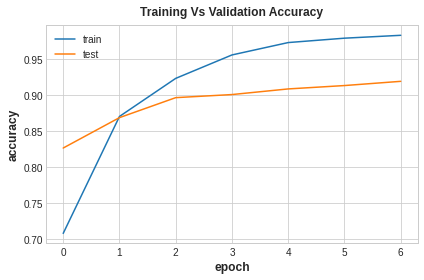

In [ ]:
# plot accuracy (train vs val)
plt.plot(history_Albert.history['categorical_accuracy'])
plt.plot(history_Albert.history['val_categorical_accuracy'])
plt.title('Training Vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

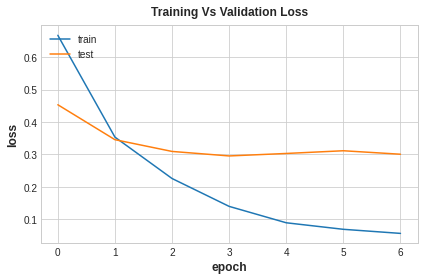

In [ ]:
# plot loss (train vs val)
plt.plot(history_Albert.history['loss'])
plt.plot(history_Albert.history['val_loss'])
plt.title('Training Vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# albert results

In [ ]:
result_albert = model.predict([test_input_ids,test_attention_masks])

76/76 [==============================] - 25s 285ms/step


In [ ]:
y_pred_albert =  np.zeros_like(result_albert)
y_pred_albert[np.arange(len(y_pred_albert)), result_albert.argmax(1)] = 1

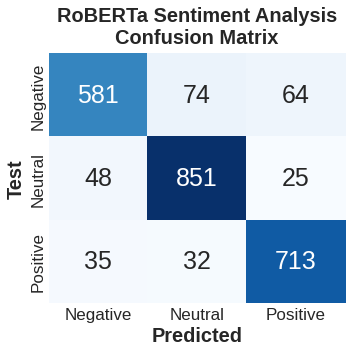

In [ ]:
conf_matrix(y_test.argmax(1),y_pred_albert.argmax(1),'RoBERTa Sentiment Analysis\nConfusion Matrix')

In [ ]:
print('\tClassification Report for albert:\n\n',classification_report(y_test,y_pred_albert, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for albert:

               precision    recall  f1-score   support

    Negative       0.88      0.81      0.84       719
     Neutral       0.89      0.92      0.90       924
    Positive       0.89      0.91      0.90       780

   micro avg       0.89      0.89      0.89      2423
   macro avg       0.88      0.88      0.88      2423
weighted avg       0.88      0.89      0.88      2423
 samples avg       0.89      0.89      0.89      2423



In [ ]:
print('Prediction Accuracy AlBERT:', "{:.2f}".format(100*accuracy_score(y_test,y_pred_albert))+"%")

Prediction Accuracy AlBERT: 88.53%
